In [1]:
%matplotlib notebook

%config Completer.use_jedi = False

In [2]:
from pathlib import Path

import sys
#sys.path.insert(0,"/Users/danakoeppe/PipelineProjects/SAMOS_DRP/SAMOS_Draft/")

import os
#current working directory
cwd = os.getcwd() 
print(cwd)

#parent directort
parent_directory = os.path.dirname(cwd)
print(parent_directory)
sys.path.insert(0,parent_directory)

/Users/robberto/Desktop/SAMOS_pipeline/SAMOS_DataReductionPipeline-dev/NotebookTests
/Users/robberto/Desktop/SAMOS_pipeline/SAMOS_DataReductionPipeline-dev


In [3]:
import ccdproc as ccdp
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import LogNorm
from PIPELINE.convenience_functions import show_image

from astropy.utils.data import get_pkg_data_filename
from astropy.table import Table
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import importlib


#import ccdproc  #mr: alreay imported as ccdproc 


from itertools import groupby

from PIL import Image as P

#general os
import os
import zipfile
import urllib.request

#general plotting
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

params={'legend.fontsize':'18','axes.labelsize':'18',
        'axes.titlesize':'18','xtick.labelsize':'18',
        'ytick.labelsize':'18','lines.linewidth':2,'axes.linewidth':2,'animation.html': 'html5'}
plt.rcParams.update(params)
plt.rcParams.update({'figure.max_open_warning': 0})

#table/math handling
import pandas as pd
import numpy as np
np.seterr(all='ignore')  # hides irrelevant warnings about divide-by-zero, etc

#astropy
import astropy
import astropy.units as u
from astropy.table import QTable
from astropy.io import fits,ascii
from astropy.nddata import StdDevUncertainty
from astropy.modeling import models, fitting
from astropy.visualization import quantity_support,astropy_mpl_style, simple_norm
from astropy import constants as const
from astropy.stats import mad_std
from astropy.nddata import CCDData
from astropy.visualization import hist
from PIPELINE.convenience_functions import show_image, display_cosmic_rays

#specutils
import specutils
from specutils import Spectrum1D, SpectralRegion
from specutils.manipulation import gaussian_smooth
from specutils.fitting import fit_generic_continuum
from specutils.fitting import find_lines_derivative
from specutils.fitting import find_lines_threshold
from specutils.fitting import fit_lines
from specutils.manipulation import noise_region_uncertainty
from specutils.analysis import centroid
from specutils.analysis import line_flux
from specutils.analysis import equivalent_width
from specutils.analysis import template_comparison

quantity_support();  # auto-recognizes units on matplotlib plots

from ipywidgets import interact
import ipywidgets as widgets

ImportError: cannot import name 'block_reduce' from 'astropy.nddata.utils' (/opt/anaconda3/envs/stenv-py3.11-2024.02.05/lib/python3.11/site-packages/astropy/nddata/utils.py)

In [11]:

def trim_raw_dir(goodman_files):
    remove_list = []
    for img in goodman_files.files:
        img_path = os.path.join(raw_goodman_path,img)
        ccd = CCDData.read(img_path,unit='adu')
        
        if ccd.header['instconf'].lower()=="blue":
            
            os.remove(img_path)
            continue
        
        if ccd.header['wavmode'].lower()=="custom":
            os.remove(img_path)
            continue

        old_slit_val = ccd.header['slit']
        new_slit_val = old_slit_val.replace('"','').replace(' ','_').upper()

        old_grating_val = ccd.header['grating'].split('_')

        if old_grating_val[0]=='SYZY':
            new_grating_val = old_grating_val[1]+'_'+old_grating_val[0]
            ccd.header['grating'] = new_grating_val

        old_wavmode_val = ccd.header['wavmode']
        new_wavmode_val = old_wavmode_val.replace(' ','_').upper()


        ccd.header['slit'] = new_slit_val

        ccd.header['wavmode'] = new_wavmode_val

        if new_wavmode_val=="ZZ_CETI_RED":
            remove_list.append(img_path)
        if new_slit_val!="1.0_LONG_SLIT":
            #print(img,new_slit_val)
            remove_list.append(img_path)

        ccd.write(Path(raw_goodman_path) / img,overwrite=True)

    for im in remove_list:
        try:
            pass
            #os.remove(im)
        except:
            pass
        
    

In [12]:


log_filename = "SAMOS_goodman_single_slit_testing.log"

log_format = '[%(asctime)s][%(levelname)8s]: %(message)s ' \
                     '[%(module)s.%(funcName)s:%(lineno)d]'
date_format = '%H:%M:%S'

if os.path.exists(log_filename):
    os.remove(log_filename)

import logging
import logging.config
importlib.reload(logging)
importlib.reload(logging.config)


logging.basicConfig(level=logging.DEBUG,
                   filename=log_filename)

formatter = logging.Formatter(fmt=log_format,
                              datefmt=date_format)

file_handler = logging.FileHandler(filename=log_filename)
file_handler.setFormatter(fmt=formatter)
file_handler.setLevel(level=logging.DEBUG)


log = logging.getLogger(__name__)

log.addHandler(file_handler)
log.addHandler(logging.StreamHandler())



In [13]:
raw_goodman_path = "/Users/danakoeppe/goodman_spec_pipeline/goodman_redcam_single_slit_2019-04-26/raw_data/"

compressed_raw_goodpath = "/Users/danakoeppe/goodman_spec_pipeline/test_gsp_run/compressed_goodman_data/"

""


procdir = "goodman_test_products"
if os.path.exists("goodman_test_products"):
    try:
        for f in os.listdir("goodman_test_products"):
            os.remove(os.path.join(procdir,f))
    except:
        pass
else:
    os.mkdir("goodman_test_products")
    
goodman_files =  ccdp.ImageFileCollection(raw_goodman_path)
trim_raw_dir(goodman_files)
goodman_summary = goodman_files.summary.to_pandas()

raw_gdm_ori = goodman_summary.file.iloc[16]
raw_gdm_flt = goodman_summary.file.iloc[2]
raw_gdm_cri = goodman_summary.file.iloc[0]

readout_configurations = goodman_files.summary.to_pandas().groupby(
            ['gain',
             'rdnoise',
             'ccdsum',
             'filter2',
             'slit',
             'grating',
             'wavmode',
             'instconf']).size().reset_index().rename(columns={0: 'count'})

readout_configurations

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


,gain,rdnoise,ccdsum,filter2,slit,grating,wavmode,instconf,count
0,1.48,3.89,2 2,<NO FILTER>,1.5_LONG_SLIT,930_SYZY,930_M2,Red,29


In [14]:
import PIPELINE.SAMOS_NIGHT as SN
importlib.reload(SN)
#importlib.reload(PIPELINE.DataBucket)


SNight = SN.SAMOSNight(raw_data_dir=raw_goodman_path,
					   obsid="fake_samos_test",
					   proc_dir=procdir,
					   LOG_FILENAME='SRP_goodman_single_slit.log',
					   ignore_bias=False,
					   ignore_flats=False)

SNight()

True
{'obsid': 'fake_samos_test', 'data_path': '/Users/danakoeppe/goodman_spec_pipeline/goodman_redcam_single_slit_2019-04-26/raw_data/', 'gain': 1.48, 'rdnoise': 3.89, 'ccdsum': '2 2', 'empty_bucket': True, 'bias_buckets': None, 'flat_buckets': None, 'comp_buckets': None, 'targ_buckets': None, 'spec_buckets': None, 'slit_buckets': None, 'fits_slit_locs': None, 'sunset_time': None, 'sunrise_time': None, 'evening_twilight': None, 'morning_twilight': None, 'header_keys': ['naxis', 'date', 'slit', 'date-obs', 'obstype', 'object', 'exptime', 'obsra', 'obsdec', 'grating', 'cam_targ', 'grt_targ', 'filter', 'filter2', 'gain', 'rdnoise', 'ccdsum', 'wavmode']}
flat in spec group                           file  naxis        date           slit  \
10  psg_190426_091323_ori.fits      2  2019-04-26  1.5_LONG_SLIT   
11  psg_190426_092425_ori.fits      2  2019-04-26  1.5_LONG_SLIT   
12  psg_190426_093450_ori.fits      2  2019-04-26  1.5_LONG_SLIT   
13  psg_190426_094500_ori.fits      2  2019-04-26

[<class 'PIPELINE.DataBucket.DataBucket'>
 SAMOS Observation ID: fake_samos_test
 Data Directory: 
 Working Directory: NotebookTests
 Gain: 1.48
 Readout Noise: 3.89
 ccdsum: 2 2
 Is Empty: False
 
 Bucket Grouping Information
 
 (small buckets inside bigger bucekts!)
 BIAS Group:
 Files in BUCKET
   psg_190425_202339_zri.fits
   psg_190425_202349_zri.fits
   psg_190425_202359_zri.fits
   psg_190425_202409_zri.fits
   psg_190425_202419_zri.fits
   psg_190425_202429_zri.fits
   psg_190425_202439_zri.fits
   psg_190425_202449_zri.fits
   psg_190425_202459_zri.fits
   psg_190425_202509_zri.fits
 FLATs Group:
 Files in BUCKET
   psg_190426_203417_fri.fits
   psg_190426_203432_fri.fits
   psg_190426_203447_fri.fits
   psg_190426_203502_fri.fits
   psg_190426_203517_fri.fits
   psg_190426_203532_fri.fits
   psg_190426_203547_fri.fits
   psg_190426_203602_fri.fits
   psg_190426_203617_fri.fits
   psg_190426_203632_fri.fits
   psg_190426_203647_fri.fits
   psg_190426_203702_fri.fits
   psg_190

In [15]:
from ccdproc import ImageFileCollection
from PIPELINE.DataBucket import DataBucket
from astropy.coordinates import SkyCoord
import astropy.units as units

full_bucket = ImageFileCollection(SNight.raw_data_dir,SNight.header_keys).summary.to_pandas()


full_bucket['radeg'] = ''
full_bucket['decdeg'] = ''
for i in full_bucket.index.tolist():
    SCs = SkyCoord(full_bucket.obsra.iloc[i],
                   full_bucket.obsdec.iloc[i],
                   unit=(units.hourangle,units.deg))
    radeg,decdeg = SCs.ra,SCs.dec

    full_bucket.iloc[
        i, full_bucket.columns.get_loc('radeg')] = \
        '{:.2f}'.format(radeg)

    full_bucket.iloc[
        i, full_bucket.columns.get_loc('decdeg')] = \
        '{:.2f}'.format(decdeg)
            
readout_configurations = full_bucket.groupby(
            ['gain',
             'rdnoise',
             'ccdsum']).size().reset_index().rename(columns={0: 'count'})


dbuckets = DataBucket("trythis",SNight.raw_data_dir)

for i in readout_configurations.index:
    configuration_buckets = full_bucket[
                    ((full_bucket['gain'] ==
                      readout_configurations.iloc[i]['gain']) &
                     (full_bucket['rdnoise'] ==
                      readout_configurations.iloc[i]['rdnoise']) &
                     (full_bucket['ccdsum'] ==
                      readout_configurations.iloc[i]['ccdsum']))]

bucket_collection = full_bucket[full_bucket.obstype != 'BIAS']

configurations = bucket_collection.groupby(['slit',
                          'radeg',
                          'decdeg',
                          'grating',
                          'cam_targ',
                          'grt_targ',
                          'filter',
                          'filter2',
                          'gain',
                          'rdnoise']).size().reset_index().rename(columns={0: 'count'})

for i in configurations.index:
    print(i)
    data_bucket_group = bucket_collection[(
        (bucket_collection['slit'] == configurations.iloc[i]['slit']) &
        (bucket_collection['radeg'] == configurations.iloc[i]['radeg']) &
        (bucket_collection['decdeg'] == configurations.iloc[i]['decdeg']) &
        (bucket_collection['grating'] == configurations.iloc[i]['grating']) &
        (bucket_collection['cam_targ'] == configurations.iloc[i]['cam_targ']) &
        (bucket_collection['grt_targ'] == configurations.iloc[i]['grt_targ']) &
        (bucket_collection['filter2'] == configurations.iloc[i]['filter2']) &
        (bucket_collection['gain'] == configurations.iloc[i]['gain']) &
        (bucket_collection['rdnoise'] == configurations.iloc[i]['rdnoise']))]

    group_obstype = data_bucket_group.obstype.unique()
    print(group_obstype)

SNight.data_buckets.targ_buckets

0
['OBJECT' 'COMP' 'FLAT']


[                          file  naxis        date           slit  \
 10  psg_190426_091323_ori.fits      2  2019-04-26  1.5_LONG_SLIT   
 11  psg_190426_092425_ori.fits      2  2019-04-26  1.5_LONG_SLIT   
 12  psg_190426_093450_ori.fits      2  2019-04-26  1.5_LONG_SLIT   
 13  psg_190426_094500_ori.fits      2  2019-04-26  1.5_LONG_SLIT   
 
                    date-obs obstype        object  exptime         obsra  \
 10  2019-04-26T09:13:23.196  OBJECT  WDJ1743-3908    600.0  17:43:49.400   
 11  2019-04-26T09:24:25.054  OBJECT  WDJ1743-3908    600.0  17:43:49.400   
 12  2019-04-26T09:34:50.811  OBJECT  WDJ1743-3908    600.0  17:43:49.400   
 13  2019-04-26T09:45:00.796  OBJECT  WDJ1743-3908    600.0  17:43:49.400   
 
            obsdec  ... cam_targ  grt_targ       filter      filter2  gain  \
 10  -39:08:10.802  ...     25.2      12.6  <NO FILTER>  <NO FILTER>  1.48   
 11  -39:08:10.802  ...     25.2      12.6  <NO FILTER>  <NO FILTER>  1.48   
 12  -39:08:10.802  ...     25.2

In [16]:
SNight.data_buckets.targ_buckets

[                          file  naxis        date           slit  \
 10  psg_190426_091323_ori.fits      2  2019-04-26  1.5_LONG_SLIT   
 11  psg_190426_092425_ori.fits      2  2019-04-26  1.5_LONG_SLIT   
 12  psg_190426_093450_ori.fits      2  2019-04-26  1.5_LONG_SLIT   
 13  psg_190426_094500_ori.fits      2  2019-04-26  1.5_LONG_SLIT   
 
                    date-obs obstype        object  exptime         obsra  \
 10  2019-04-26T09:13:23.196  OBJECT  WDJ1743-3908    600.0  17:43:49.400   
 11  2019-04-26T09:24:25.054  OBJECT  WDJ1743-3908    600.0  17:43:49.400   
 12  2019-04-26T09:34:50.811  OBJECT  WDJ1743-3908    600.0  17:43:49.400   
 13  2019-04-26T09:45:00.796  OBJECT  WDJ1743-3908    600.0  17:43:49.400   
 
            obsdec  ... cam_targ  grt_targ       filter      filter2  gain  \
 10  -39:08:10.802  ...     25.2      12.6  <NO FILTER>  <NO FILTER>  1.48   
 11  -39:08:10.802  ...     25.2      12.6  <NO FILTER>  <NO FILTER>  1.48   
 12  -39:08:10.802  ...     25.2

In [17]:
import PIPELINE.ImageProcessor as ImProc
import PIPELINE.SAMOS_mods as Smods
importlib.reload(Smods)
importlib.reload(ImProc)


SN_ccd = ImProc.ImageProcessor(SNight,num_expected_slits=1)
SN_ccd()



INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


science_image shape: (948, 2071), master_bias shape: (948, 2071)
psg_190426_091323_ori.fits master_bias_2x2_R3d89_G1d48.fits
master bias shape: (948, 2071)
 current ccd shape: (948, 2071)
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


science_image shape: (948, 2071), master_bias shape: (948, 2071)
psg_190426_092425_ori.fits master_bias_2x2_R3d89_G1d48.fits
master bias shape: (948, 2071)
 current ccd shape: (948, 2071)
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


science_image shape: (948, 2071), master_bias shape: (948, 2071)
psg_190426_093450_ori.fits master_bias_2x2_R3d89_G1d48.fits
master bias shape: (948, 2071)
 current ccd shape: (948, 2071)
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


science_image shape: (948, 2071), master_bias shape: (948, 2071)
psg_190426_094500_ori.fits master_bias_2x2_R3d89_G1d48.fits
master bias shape: (948, 2071)
 current ccd shape: (948, 2071)
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


science_image shape: (948, 2071), master_bias shape: (948, 2071)
psg_190426_202527_cri.fits master_bias_2x2_R3d89_G1d48.fits
master bias shape: (948, 2071)
 current ccd shape: (948, 2071)
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


science_image shape: (948, 2071), master_bias shape: (948, 2071)
psg_190426_202850_cri.fits master_bias_2x2_R3d89_G1d48.fits
master bias shape: (948, 2071)
 current ccd shape: (948, 2071)
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


985 1015
[[ 96 882]] False 1
492 522
[[ 96 883]] False 1
999 1029
[[ 96 882]] False 1
1506 1536
[[ 94 881]] False 1
1911 1941
[[ 93 351]
 [351 806]
 [855 881]] False 1
1985 2015
None True 1
[array([[ 96, 882]]), array([[ 96, 883]]), array([[ 96, 882]]), array([[ 94, 881]])]
okay


In [18]:
from PIPELINE.SAMOS_mods import get_overscan_region,define_trim_section

rawccd = "/Users/danakoeppe/goodman_spec_pipeline/test_gsp_run/uncompressed_goodman_data/goodman_red/psg_190426_094500_ori.fits"

define_trim_section(rawccd),SN_ccd.trim_section

AssertionError: 

In [19]:
import PIPELINE.SlitBuckets2 as Slits
import PIPELINE.slit_tracing_mods as stm
import PIPELINE.SAMOSHelpers
importlib.reload(PIPELINE.SAMOSHelpers)
importlib.reload(Slits)
importlib.reload(stm)
importlib.reload(Smods)



SN_slits = Slits.SlitBuckets(SN_ccd)
SN_slits()


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


In [20]:
import PIPELINE.ReDoWavecal as DoWv
importlib.reload(DoWv)
import PIPELINE.Spectroscopy.wavelength
importlib.reload(PIPELINE.Spectroscopy.wavelength)
import PIPELINE.Spectroscopy.wcs
importlib.reload(PIPELINE.Spectroscopy.wcs)


SN_wv = DoWv.WaveCalBuckets(SN_slits)

SN_wv()


reference lamp location: /Users/danakoeppe/PipelineProjects/SAMOS_DRP/SAMOS_Draft/NotebookTests/../comp_refs
True
TESTING
ftz_combined_WDJ1743-3908_930_1.5_05.fits
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


<class 'astropy.modeling.polynomial.Chebyshev1D'>
Name: Chebyshev1D
N_inputs: 1
N_outputs: 1
Fittable parameters: <property object at 0x7feef9cd3680> <class 'astropy.modeling.polynomial.Chebyshev1D'>
Name: Chebyshev1D
N_inputs: 1
N_outputs: 1
Fittable parameters: <property object at 0x7feef9cd3680>
ftz_combined_Cu_930_1.5_01.fits goodman_test_products/wftz_combined_Cu_930_1.5_01_ws_1.fits
goodman_test_products/wftz_combined_Cu_930_1.5_01_ws_1.fits
ftz_combined_WDJ1743-3908_930_1.5_05.fits goodman_test_products/wftz_combined_WDJ1743-3908_930_1.5_05_ws_1.fits
goodman_test_products/wftz_combined_WDJ1743-3908_930_1.5_05_ws_1.fits


In [23]:
from PIPELINE.SAMOS_mods import add_wcs_keys,read_fits
from PIPELINE.SAMOS_mods import image_trim
import PIPELINE.Spectroscopy.wcs
import PIPELINE.Spectroscopy.wavelength
from PIPELINE.Spectroscopy.wavelength import WavelengthCalibration

Tccd = SN_slits.slit_targs[0]
Cccd = SN_slits.slit_comps[0]

wcs_starg = add_wcs_keys(Tccd)
wcs_scomp = add_wcs_keys(Cccd)

wavecal = WavelengthCalibration()

targ1D = CCDData(np.median(Tccd.data,axis=0),unit='adu')
targ1D.header = wcs_starg.header.copy()
comp1D = CCDData(np.median(Cccd.data,axis=0),unit='adu')
comp1D.header = wcs_scomp.header.copy()

#Tccd = ccdproc.CCDData(Tccd.data,header=Tccd.header,unit='adu')

rawccd.header['trimsec'],SN_ccd.trim_section,Tccd.data[np.isnan(Tccd.data)],Tccd.header['']

KeyError: "Keyword 'OSCAN' not found."

(array([], dtype=float64), (797, 2041), (948, 2041), (797, 2027), (948, 2041))

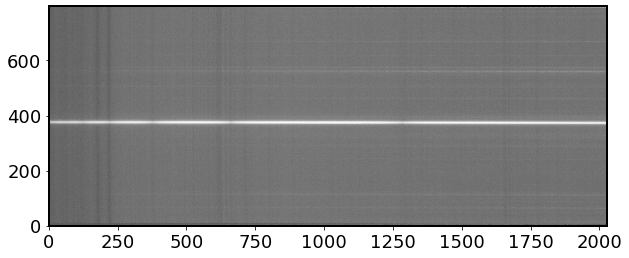

In [20]:
%matplotlib inline 

rawccd = CCDData.read("/Users/danakoeppe/goodman_spec_pipeline/test_gsp_run/uncompressed_goodman_data/goodman_red/psg_190426_094500_ori.fits")

rawccd_trimmed = ccdproc.trim_image(ccd=rawccd,fits_section=SN_ccd.trim_section)

Tccd_trimmed = ccdproc.trim_image(ccd=Tccd,fits_section=SN_ccd.trim_section)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()

ftzcomb = CCDData.read("goodman_test_products/ftzpsg_190426_091323_ori.fits")
er_norm = simple_norm(Tccd_trimmed, stretch='log')


oimg_poly = ax.imshow(Tccd_trimmed, cmap='gray', interpolation='none',origin='lower',norm=er_norm)


Tccd_trimmed.data[np.isnan(Tccd_trimmed.data)],Tccd.shape,ftzcomb.data.shape,Tccd_trimmed.shape,rawccd_trimmed.shape

In [177]:
import PIPELINE.SAMOS_mods
importlib.reload(PIPELINE.SAMOS_mods)
from PIPELINE.SAMOS_mods import create_slit_cutout_polygon, trace_slit_edges_from_cross_disp_coadd

import scipy
import matplotlib

from astropy.visualization import simple_norm

from PIPELINE.convenience_functions import show_image

ccd = CCDData.read("./goodman_test_products/norm_master_flat_930Custom_4691nm_1.5.fits")
ccd = CCDData.read("./goodman_test_products/master_flat_930Custom_4691nm_1.5.fits")

all_verts, all_polys = create_slit_cutout_polygon(ccd,std_thresh_height=10)
gauss_smooth_std = 8
std_thresh_height = 10
third_x = ccd.shape[1]//3
quart_x = ccd.shape[1]//4
slice_cols = [1000,quart_x, quart_x*2, quart_x*3, int(quart_x*3.8),ccd.shape[1]-slice_width]

all_pairs = []
pair_slice_cols = []
for i in slice_cols:
    #print(i)
    pairs, dpc = trace_slit_edges_from_cross_disp_coadd(ccd,col=i,
                                            slice_width=slice_width,
                                            gauss_smooth_std=gauss_smooth_std,
                                            std_thresh_height=std_thresh_height)
    
    if pairs is None:
        continue

    print(len(pairs))


    pair_slice_cols.append(i)
    all_pairs.append(np.vstack(pairs))



985 1015
495 525
1005 1035
1515 1545
1923 1953
1996 2026
985 1015
1
495 525
1
1005 1035
1
1515 1545
1
1923 1953
1996 2026
2


In [156]:
lst = ["hey", "hey",1,"you",2,"try",3,"this"]

np.where(lst=="hey"),lst[lst=="you"]

((array([], dtype=int64),), 'hey')

In [11]:
ori_filepath = os.path.join(raw_goodman_path,raw_gdm_ori)


raw_ori_hdu = fits.open(os.path.join(raw_goodman_path,raw_gdm_ori))
raw_flt_hdu = fits.open(os.path.join(raw_goodman_path,raw_gdm_flt))

raw_flt_data = raw_flt_hdu[0].data
oriCCD = CCDData.read(os.path.join(raw_goodman_path,raw_gdm_ori),unit='adu')

raw_ori_data = raw_ori_hdu[0].data

image_shape = raw_ori_data.shape
norm = simple_norm(raw_ori_data, stretch='log')
aspect_ratio = image_shape[1] / (2 * image_shape[0])
fig1 = plt.figure() # we save these in dummy variables to avoid spurious Jupyter Notebook output
img1 = plt.imshow(raw_ori_data, cmap='gray', aspect=aspect_ratio, 
                  norm=norm, interpolation='none')
clb1 = plt.colorbar()

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


In [12]:
raw_flat_list = []
raw_comp_list = []
raw_obj_list = []
raw_bias_list = []



for img in goodman_files.files:
    ccd = CCDData.read(os.path.join(raw_goodman_path,img),unit='adu')
    
    
    if ccd.header['obstype']=="FLAT":
        raw_flat_list.append(ccd)
        
    elif ccd.header['obstype']=="COMP":
        raw_comp_list.append(ccd)
        
    elif ccd.header['obstype']=="OBJECT":
        raw_obj_list.append(ccd)
    
    elif ccd.header['obstype']=="BIAS":
        raw_bias_list.append(ccd)
        
        
        
        
raw_test_obj = raw_obj_list[0]

raw_ori_data = raw_test_obj.data
image_shape = raw_test_obj.shape

raw_test_flat = raw_flat_list[0]
raw_flat_data = raw_test_flat.data


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


In [13]:

master_bias_list = raw_bias_list


    
combined_bias = ccdp.combine(master_bias_list,
                             method='median',
                             sigma_clip=True, sigma_clip_low_thresh=3.0, sigma_clip_high_thresh=3.0,
                             add_keyword=False)

combined_bias.meta['combined'] = True

combined_bias.write(Path(procdir) / 'combined_bias.fits',overwrite=True)

In [14]:
plt.figure()
plt.imshow(combined_bias,cmap='gray')
combined_bias.shape

(948, 2071)

In [15]:
oscanned_flats = []
oscanned_comps = []
oscanned_objs = []


master_flat_list = []
for bucket in [groups for groups in [raw_flat_list,raw_comp_list,raw_obj_list]]:
    
    for raw_ccd in bucket:
        
        spatial_length, dispersion_length = raw_ccd.data.shape
        serial_binning, parallel_binning = \
        [int(x) for x in raw_ccd.header['CCDSUM'].split()]
    
        low_lim_spectral, \
        high_lim_spectral, \
        low_lim_spatial, \
        high_lim_spatial = [None] * 4

        low_lim_spectral = int(np.ceil(51. / serial_binning))

        # right
        high_lim_spectral = int(4110 / serial_binning)

        # bottom
        low_lim_spatial = 2

        # top
        # t = int(1896 / parallel_binning)
        # TODO (simon): Need testing
        # trim_section = '[{:d}:{:d},{:d}:{:d}]'.format(l, r, b, t)
        trim_section = '[{:d}:{:d},{:d}:{:d}]'.format(
            low_lim_spectral,
            high_lim_spectral,
            low_lim_spatial,
            spatial_length)

        overscan_region = '[{:d}:{:d},{:d}:{:d}]'.format(
            low_lim_spectral,
            high_lim_spectral,
            low_lim_spatial,
            spatial_length)


       
        #print(raw_ccd.header['DTNSANAM'])
        
        bccd = ccdp.subtract_bias(raw_ccd,combined_bias,add_keyword=False)
        
        tbccd = ccdp.trim_image(bccd,fits_section=trim_section) #not using os subtracted, using raw
        
        
        orig_fname = os.path.split(raw_ccd.header['DTNSANAM'])[1].replace(".fz","")
        
        if raw_ccd.header['obstype']=="FLAT":
            print(orig_fname)
            oscanned_flats.append(tbccd)
            master_flat_list.append(tbccd)
            
        
        elif raw_ccd.header['obstype']=="COMP":
            oscanned_comps.append(tbccd)
        
        elif raw_ccd.header['obstype']=="OBJECT":
            #tbccd = ccdp.cosmicray_lacosmic(tbccd, readnoise=10, sigclip=7, verbose=True)
            oscanned_objs.append(tbccd)
            
            
        new_fname = os.path.join(procdir,"tb_"+orig_fname)
        if os.path.exists(new_fname):
            os.remove(new_fname)
        
        tbccd.write(new_fname,format='fits')
        


psg_190425_201835_fri.fits
psg_190425_201850_fri.fits


In [44]:
master_flat = ccdproc.combine(master_flat_list,
                                      method='median',
                                      sigma_clip=True,
                                      sigma_clip_low_thresh=1.0,
                                      sigma_clip_high_thresh=1.0,
                                      add_keyword=False)


master_flat.write(Path(procdir) / 'master_flat.fits',overwrite=True)

model_init = models.Chebyshev1D(degree=15)
model_fitter = fitting.LevMarLSQFitter()

# get data shape
x_size, y_size = master_flat.data.shape
x_axis = range(y_size)

# get profile along dispersion axis to fit a model to use for
# normalization
profile = np.median(master_flat.data, axis=0)

# do the actual fit
fit = model_fitter(model_init, x_axis, profile)

# convert fit into an array
fit_array = fit(x_axis)

# pythonic way to divide an array by a vector
master_flat.data = master_flat.data / fit_array[None, :]

master_flat.write(Path(procdir) / 'normed_master_flat.fits',overwrite=True)


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


Starting 4 L.A.Cosmic iterations
Iteration 1:
2584 cosmic pixels this iteration
Iteration 2:
31 cosmic pixels this iteration
Iteration 3:
3 cosmic pixels this iteration
Iteration 4:
3 cosmic pixels this iteration
Starting 4 L.A.Cosmic iterations
Iteration 1:
2369 cosmic pixels this iteration
Iteration 2:
16 cosmic pixels this iteration
Iteration 3:
0 cosmic pixels this iteration
Starting 4 L.A.Cosmic iterations
Iteration 1:
2314 cosmic pixels this iteration
Iteration 2:
23 cosmic pixels this iteration
Iteration 3:
1 cosmic pixels this iteration
Iteration 4:
1 cosmic pixels this iteration
Starting 4 L.A.Cosmic iterations
Iteration 1:
2409 cosmic pixels this iteration
Iteration 2:
42 cosmic pixels this iteration
Iteration 3:
4 cosmic pixels this iteration
Iteration 4:
2 cosmic pixels this iteration
Starting 4 L.A.Cosmic iterations
Iteration 1:
2330 cosmic pixels this iteration
Iteration 2:
23 cosmic pixels this iteration
Iteration 3:
5 cosmic pixels this iteration
Iteration 4:
5 cosmic p

<IPython.core.display.Javascript object>


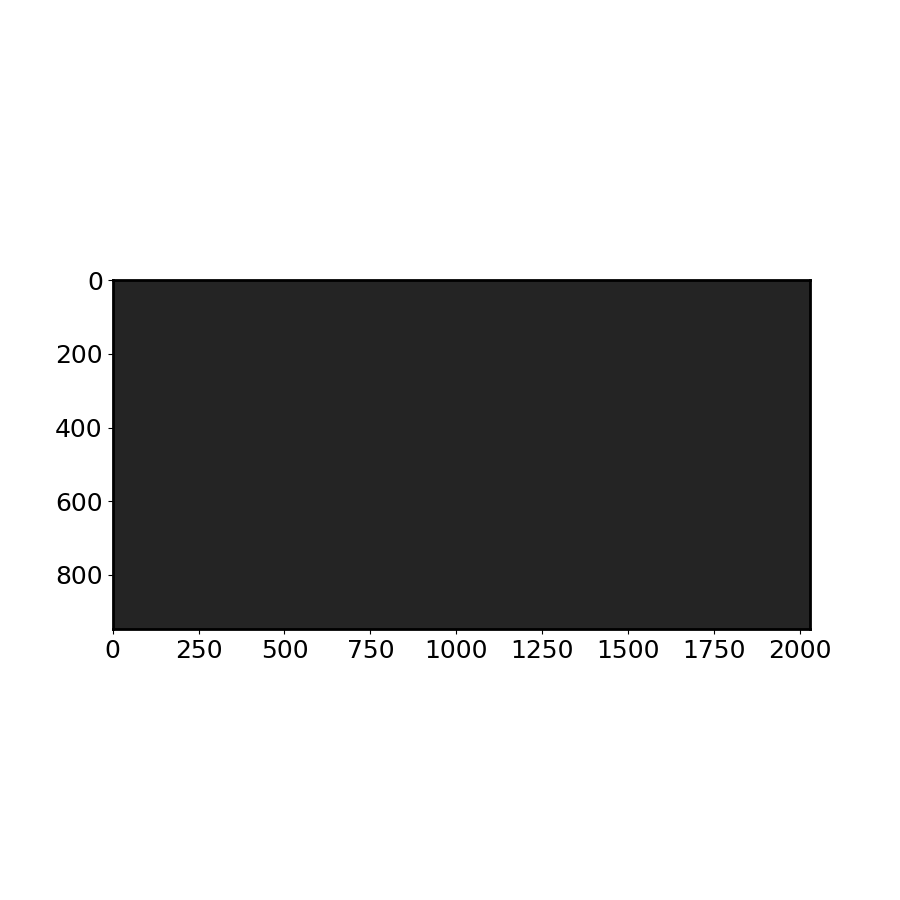

In [57]:


flatcorr_comps = []
flatcorr_objs = []

for bucket in [groups for groups in [oscanned_comps,oscanned_objs]]:
    
    flat = CCDData.read(Path(procdir) / 'normed_master_flat.fits',unit='adu')
    for ccd in bucket:
        orig_fname = os.path.split(ccd.header['DTNSANAM'])[1].replace(".fz","")

        fccd = ccdp.flat_correct(ccd=ccd,flat=flat)
        if ccd.header['obstype']=="COMP":
            flatcorr_comps.append(fccd)

        elif ccd.header['obstype']=="OBJECT":
            
            cfccd = ccdp.cosmicray_lacosmic(fccd, readnoise=10, sigclip=7, verbose=True)
            flatcorr_objs.append(cfccd)


        new_fname = os.path.join(procdir,"ftb_"+orig_fname)


        fccd.write(new_fname,format='fits',overwrite=True)
    
    
test_obj_flat_corr = flatcorr_objs[0]

image_shape = test_obj_flat_corr.shape
norm = simple_norm(test_obj_flat_corr, stretch='log')
aspect_ratio = image_shape[1] / (2 * image_shape[0])


figt = plt.figure(figsize=(9,9)) # we want the largest figure that will fit in the notebook
imgt = plt.imshow(master_flat, cmap='gray', aspect=aspect_ratio, 
                  norm=norm, interpolation='none') # reuse norm from earlier

test_obj_flat_corr.write(Path(procdir) / 'test_obj_flatcorr.fits',overwrite=True,format='fits')

<IPython.core.display.Javascript object>


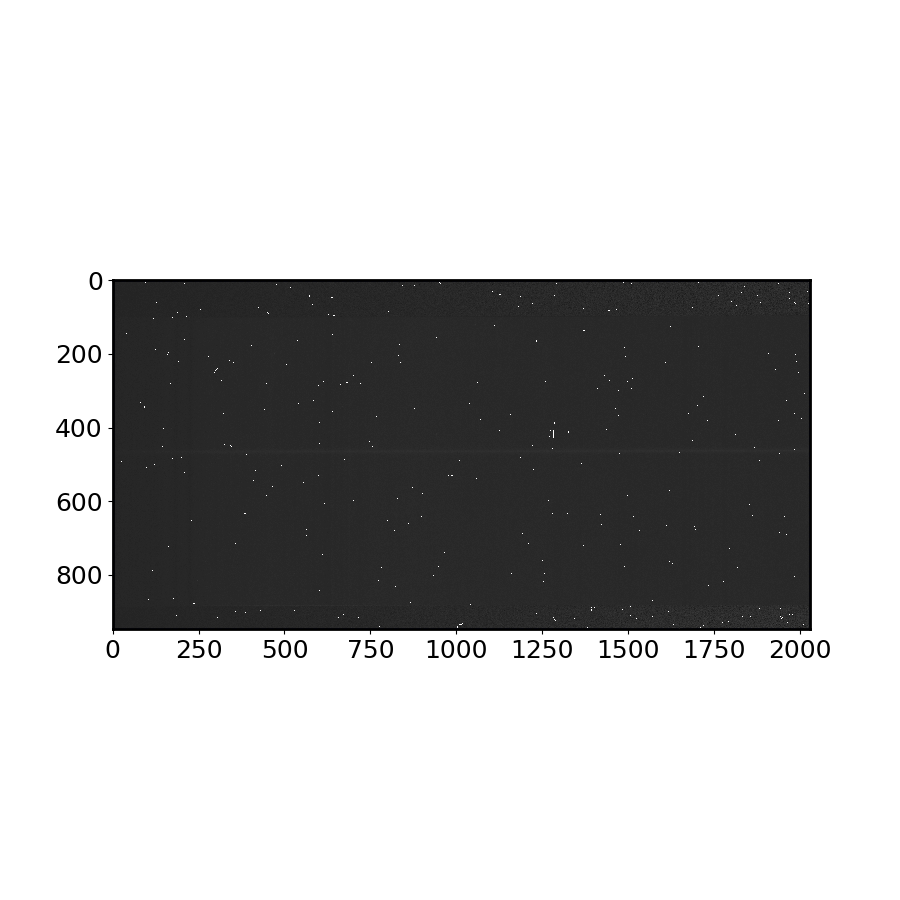

interactive(children=(IntSlider(value=0, description='x1', max=2028), IntSlider(value=0, description='y1', max…

In [58]:
fig2 = plt.figure(figsize=(9,9)) # we want the largest figure that will fit in the notebook
img2 = plt.imshow(test_obj_flat_corr, cmap='gray', aspect=aspect_ratio, 
                  norm=norm, interpolation='none') # reuse norm from earlier

# create region box and slider
region_x = region_y = 0
region_h, region_w = image_shape
region_rectangle = Rectangle((region_x, region_y), region_w, region_h, 
                             facecolor='none', edgecolor='b', linestyle='--')
current_axis = plt.gca()
current_axis.add_patch(region_rectangle)

# interactive widget controls
def region(x1=0, y1=0, x2=region_w-1, y2=region_h-1):
    region_rectangle.set_bounds(x1, y1, x2-x1, y2-y1)
    plt.draw()
    
interact1 = interact(region, x1=(0, region_w-2, 1), y1=(0, region_h-2, 1), 
                    x2=(1, region_w-1, 1), y2=(1, region_h-1, 1))

0 434 2029 481


<IPython.core.display.Javascript object>


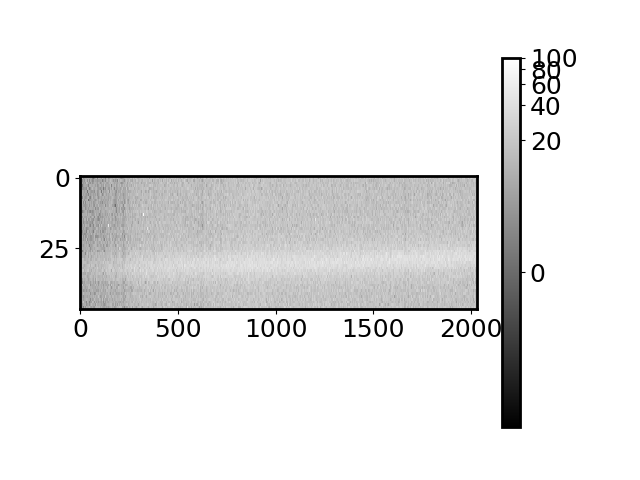

In [51]:
#comment these lines out if interativity is not desired
x, y = region_rectangle.xy
w = region_rectangle.get_width() 
h = region_rectangle.get_height()

#uncomment and set these to your desired extraction region if interativity is not desired
# x = y = 0
# h, w = image_shape

print(x, y, x+w, y+h)

er_y, er_x = np.mgrid[y:y+h, x:x+w]
extraction_region = test_obj_flat_corr.data[er_y, er_x]
weights_region = master_flat.data[er_y, er_x]
er_ny, er_nx = extraction_region.shape

aspect_ratio = er_nx / (3. * er_ny)

er_norm = simple_norm(extraction_region, stretch='log')
fig3 = plt.figure()
img3 = plt.imshow(extraction_region, cmap='gray', aspect=aspect_ratio, 
                  norm=er_norm, interpolation='none')
clb3 = plt.colorbar()

In [52]:
slice_width = 30
initial_column = er_nx // 2

def kernel_slice_coadd(width, column_idx):
    """
    Coadd a number of columns (= width) of the extraction region,
    centered on column_idx.
    """
    
    half_width = width // 2
    to_coadd = np.arange(max(0, column_idx - half_width), 
                         min(er_nx-1, column_idx + half_width))
    print(to_coadd.shape)
    return extraction_region[:, to_coadd].sum(axis=1) / width

slice_0 = kernel_slice_coadd(slice_width, initial_column)
slice_0.shape

(30,)


(47,)

<IPython.core.display.Javascript object>


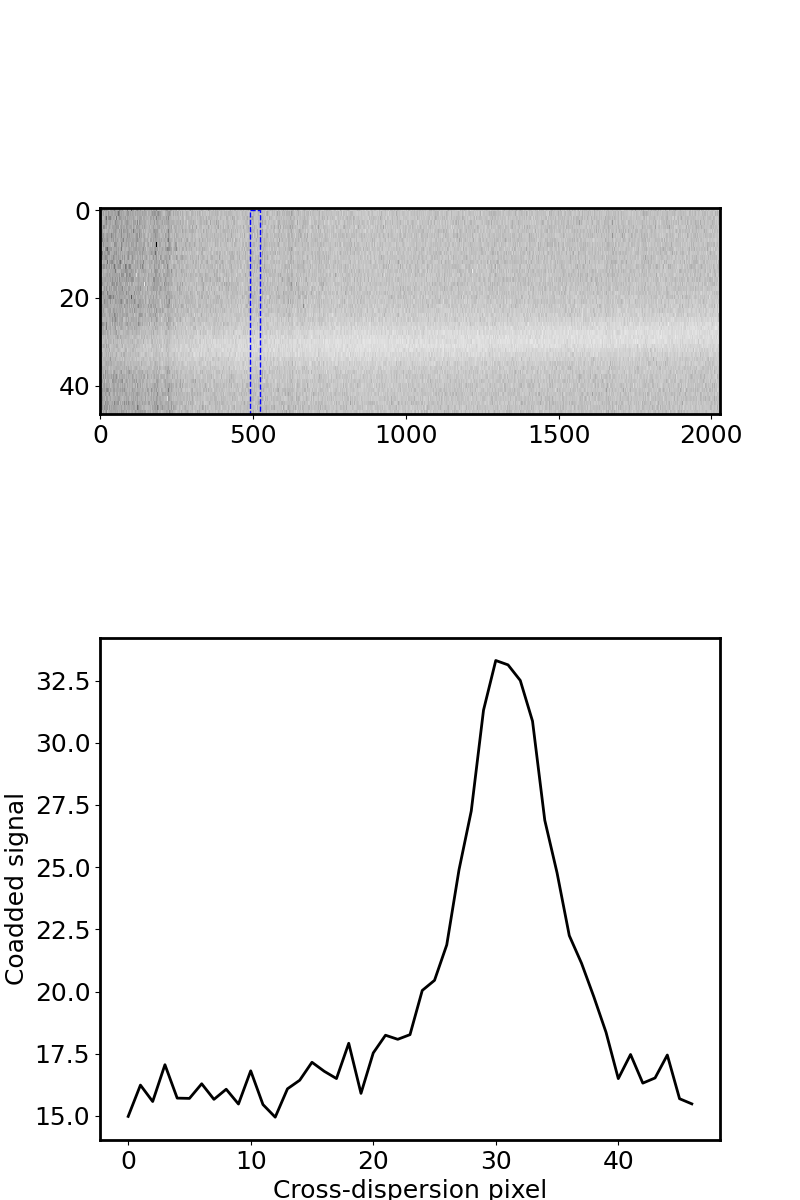

(47,) (47,)


interactive(children=(IntSlider(value=1014, description='column_idx', max=2028), IntSlider(value=30, descripti…

In [53]:
fig4, (iax4, pax4) = plt.subplots(nrows=2, ncols=1, figsize=(8, 12))
plt.subplots_adjust(hspace=0.15, top=0.95, bottom=0.05)
img4 = iax4.imshow(extraction_region, cmap='gray', aspect=aspect_ratio, 
                  norm=er_norm, interpolation='none')

#create slice box
def make_slice(width, column_idx):
    sy, sh, sw = 0, er_ny, width
    sx = column_idx - width // 2
    return sx, sy, sw, sh

*sxy, sw, sh = make_slice(slice_width, initial_column)
slice_rectangle = Rectangle(sxy, sw, sh, facecolor='none', 
                            edgecolor='b', linestyle='--')
iax4.add_patch(slice_rectangle)

#plot the coadded slice
xd_pixels = np.arange(er_ny)
print(xd_pixels.shape,slice_0.shape)
lin4, = pax4.plot(xd_pixels, slice_0, 'k-')
pax4.set_xlabel('Cross-dispersion pixel')
pax4.axes.set_ylabel('Coadded signal')

column_slider = widgets.IntSlider(initial_column, 0, er_nx-1, 1)
width_slider = widgets.IntSlider(slice_width, 1, er_nx-1, 1)

#interactive controls
def slice_update(column_idx, width):
    #update rectangle
    new_slice_box = make_slice(width, column_idx)
    slice_rectangle.set_bounds(*new_slice_box)
    #update line plot
    lin4.set_ydata(kernel_slice_coadd(width, column_idx))
    #update the axis limits
    pax4.relim()
    pax4.autoscale_view()
    plt.draw()

interact2 = interact(slice_update, column_idx=column_slider, width=width_slider)

In [17]:
kernel_slice = kernel_slice_coadd(width_slider.value, column_slider.value)

(30,)


<IPython.core.display.Javascript object>


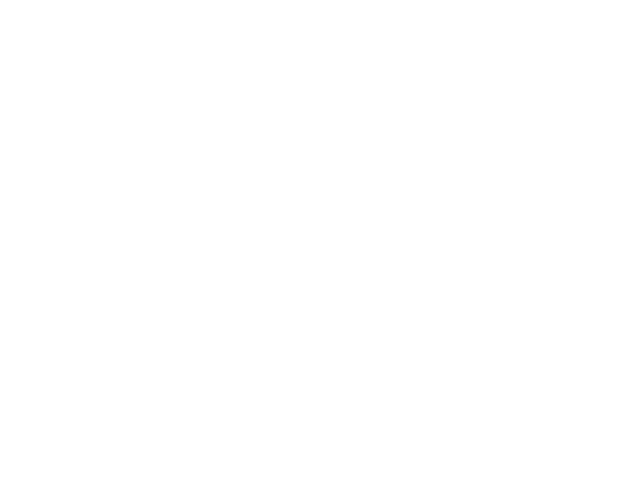

In [18]:
max_pixel = np.argmax(kernel_slice)
fwhm = 5.

moffat_profile = models.Moffat1D(amplitude=1, gamma=fwhm, x_0=max_pixel, alpha=1)
gauss_profile = models.Gaussian1D(amplitude=1, mean=max_pixel, stddev=fwhm)

fig5 = plt.figure()
kern5 = plt.plot(xd_pixels, kernel_slice / kernel_slice[max_pixel], label='Kernel Slice')
moff5 = plt.plot(xd_pixels, moffat_profile(xd_pixels), label='Moffat Profile')
gaus5 = plt.plot(xd_pixels, gauss_profile(xd_pixels), label='Gaussian Profile')
lgd5 = plt.legend()

<IPython.core.display.Javascript object>


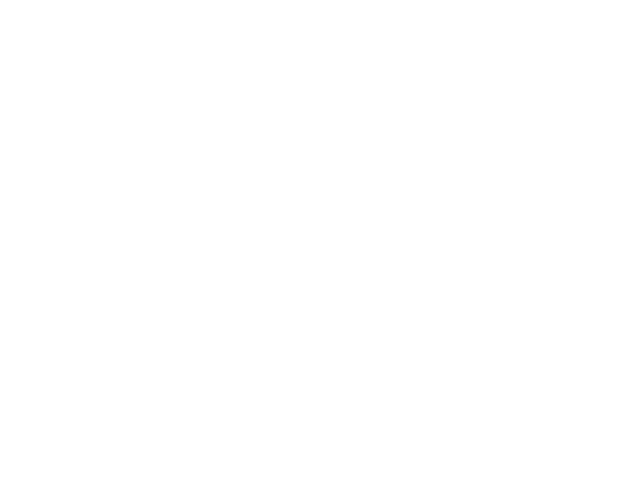

In [19]:
max_pixel = np.argmax(kernel_slice)
fwhm = 5.

moffat_profile = models.Moffat1D(amplitude=1, gamma=fwhm, x_0=max_pixel, alpha=1)
gauss_profile = models.Gaussian1D(amplitude=1, mean=max_pixel, stddev=fwhm)

fig5 = plt.figure()
kern5 = plt.plot(xd_pixels, kernel_slice / kernel_slice[max_pixel], label='Kernel Slice')
moff5 = plt.plot(xd_pixels, moffat_profile(xd_pixels), label='Moffat Profile')
gaus5 = plt.plot(xd_pixels, gauss_profile(xd_pixels), label='Gaussian Profile')
lgd5 = plt.legend()

In [20]:
psf_template = gauss_profile #moffat_profile 
psf_template.amplitude = kernel_slice[max_pixel]
print(psf_template)
# If deblending multiple sources, add more PSF templates here:
print(psf_template.param_names)
psf_txt = "     Model: {:s}\n amplitude: {:5.3f} \n      mean: {:5.3f} \n    stddev: {:5.3f}".format("Gauss",psf_template.amplitude.value,psf_template.mean.value,
                                              psf_template.stddev.value)
print(psf_txt)
psf_moff = moffat_profile
psf_mtmp = "     Model: {:s}\n amplitude: {:5.3f} \n       x_0: {:5.3f} \n     gamma: {:5.3f} \n     alpha: {:5.3f}"

print(psf_mtmp.format("moffat",psf_moff.amplitude.value, 
								   psf_moff.x_0.value, 
								   psf_moff.gamma.value,
								   psf_moff.alpha.value))

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude      mean stddev
    ----------------- ----- ------
    729.6224975585938 114.0    5.0
('amplitude', 'mean', 'stddev')
     Model: Gauss
 amplitude: 729.622 
      mean: 114.000 
    stddev: 5.000
     Model: moffat
 amplitude: 1.000 
       x_0: 114.000 
     gamma: 5.000 
     alpha: 1.000


In [21]:
background_poly = models.Polynomial1D(2)
print(background_poly)

extraction_kernel = psf_template + background_poly
print(extraction_kernel)
kernel_slice

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
     c0  c1  c2
    --- --- ---
    0.0 0.0 0.0
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian1D(amplitude=729.62249756, mean=114., stddev=5.)>

    [1]: <Polynomial1D(2, c0=0., c1=0., c2=0.)>
Parameters:
       amplitude_0    mean_0 stddev_0 c0_1 c1_1 c2_1
    ----------------- ------ -------- ---- ---- ----
    729.6224975585938  114.0      5.0  0.0  0.0  0.0


array([  3.2007368,   4.184449 ,   3.836146 ,   3.8645048,   3.524542 ,
         3.5479455,   3.0740592,   2.5444014,   4.3455863,   4.133363 ,
         3.4957306,   4.5162916,   2.991666 ,   3.7728155,   3.730691 ,
         4.7908874,   3.8323786,   3.4010577,   4.407008 ,   2.6709447,
         4.1351895,   4.154596 ,   4.5979853,   3.7555459,   3.8645136,
         3.5162663,   5.280962 ,   3.8060496,   3.9657984,   3.7837968,
         3.7230704,   4.0723457,   2.8090544,   4.629298 ,   4.838338 ,
         2.893647 ,   2.608112 ,   4.9616847,   4.008597 ,   3.784331 ,
         2.6386707,   2.6466095,   6.015153 ,   3.0220745,   3.6925685,
         4.164575 ,   2.245941 ,   4.492401 ,   4.8095975,   2.6760297,
         2.8349378,   3.620197 ,   4.2600427,   3.5360558,   3.9126983,
         4.0918765,   4.154118 ,   2.9020758,   4.361291 ,   4.315523 ,
         3.5459216,   3.0677457,   2.6403017,   3.4908586,   3.8971095,
         2.9252331,   4.008693 ,   4.766327 ,   4.330659 ,   5.2

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian1D(amplitude=725.28069803, mean=113.6130162, stddev=1.83214816)>

    [1]: <Polynomial1D(2, c0=-0.52495702, c1=0.19136275, c2=-0.00091542)>
Parameters:
       amplitude_0          mean_0       ...          c2_1         
    ----------------- ------------------ ... ----------------------
    725.2806980283763 113.61301620426947 ... -0.0009154223256239602
Parameter('mean', value=113.61301620426947)


<IPython.core.display.Javascript object>


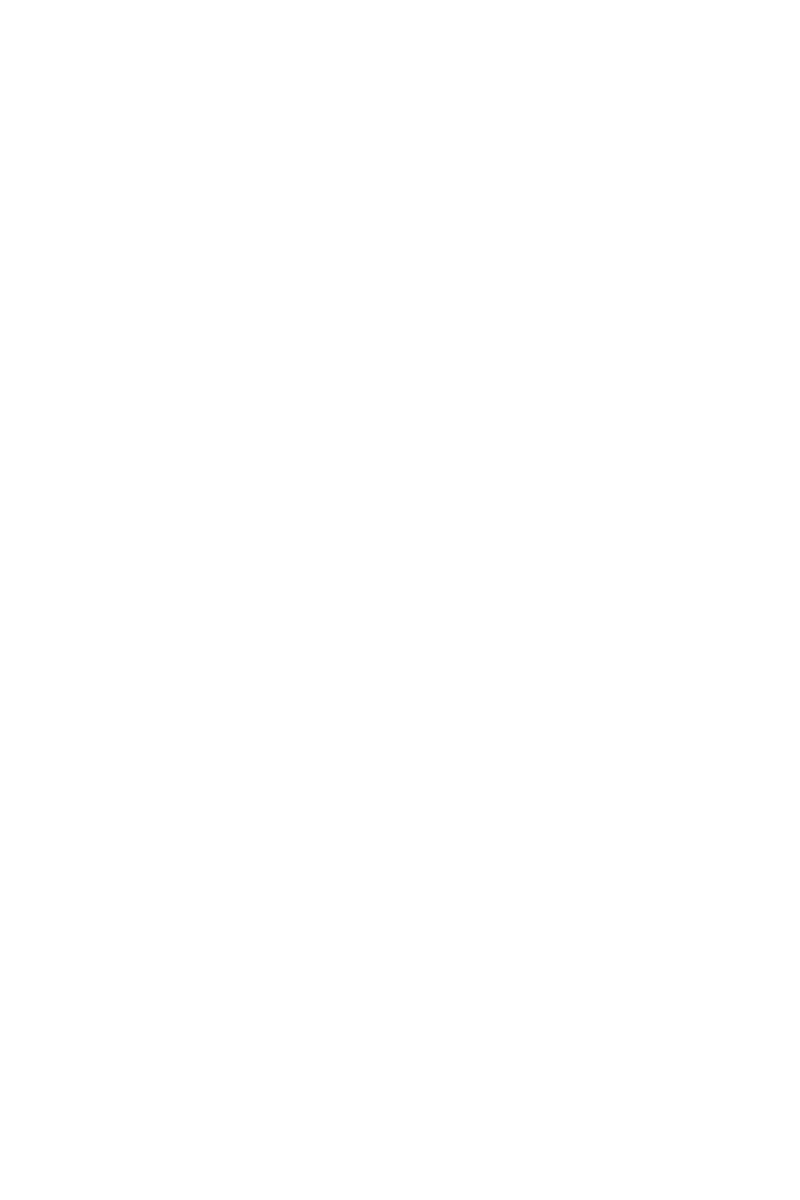

In [22]:
fitter = fitting.LevMarLSQFitter()
fit_extraction_kernel = fitter(extraction_kernel, xd_pixels, kernel_slice)
print(fit_extraction_kernel)
print(fit_extraction_kernel.mean_0)
vline1 = fit_extraction_kernel.mean_0-3*fit_extraction_kernel.stddev_0
vline2 = fit_extraction_kernel.mean_0+3*fit_extraction_kernel.stddev_0

fit_line = fit_extraction_kernel(xd_pixels)

fig6, (fax6, fln6) = plt.subplots(nrows=2, ncols=1, figsize=(8, 12))
plt.subplots_adjust(hspace=0.15, top=0.95, bottom=0.05)
psf6 = fax6.plot(xd_pixels, fit_extraction_kernel[0](xd_pixels), label="PSF")
poly6 = fax6.plot(xd_pixels, fit_extraction_kernel[1](xd_pixels), label="Background")
sum6 = fax6.plot(xd_pixels, fit_line, label="Composite Kernel")
lgd6a = fax6.legend()
lin6 = fln6.plot(xd_pixels, kernel_slice, label='Kernel Slice')
fit6 = fln6.plot(xd_pixels, fit_line, 'o', label='Extraction Kernel')
fax6.axvline(vline1)
fax6.axvline(vline2)
lgd6b = fln6.legend()

In [23]:
from astropy.stats import sigma_clip

n_bin = 100#width_slider.value
bin_width = width_slider.value
#bin_width = er_nx // n_bin
n_bin = er_nx//bin_width
print(n_bin)
bin_centers = np.arange(0, er_nx, bin_width+1, dtype=float) + bin_width // 2
col_bin_centers = bin_centers.copy()
arr = np.arange(0, er_nx, bin_width+1, dtype=float)
print(bin_centers.shape,n_bin,bin_width,er_nx,arr.shape)
binned_spectrum = np.hstack([extraction_region[:, i:i+bin_width+1].sum(axis=1)[:, None] 
                                 for i in range(0, er_nx, bin_width+1)])
bin_fwhms = np.zeros_like(bin_centers, dtype=float)

print(binned_spectrum.shape)

for binc in range(col_bin_centers.size):
    bin_fit = fitter(fit_extraction_kernel, xd_pixels, binned_spectrum[:, binc])
    bin_fwhms[binc] = bin_fit.stddev_0.value
    
    
col_bin_centers.size,col_bin_centers.shape,xd_pixels.shape,bin_width

67
(66,) 67 30 2029 (66,)
(198, 66)


(66, (66,), (198,), 30)

<IPython.core.display.Javascript object>


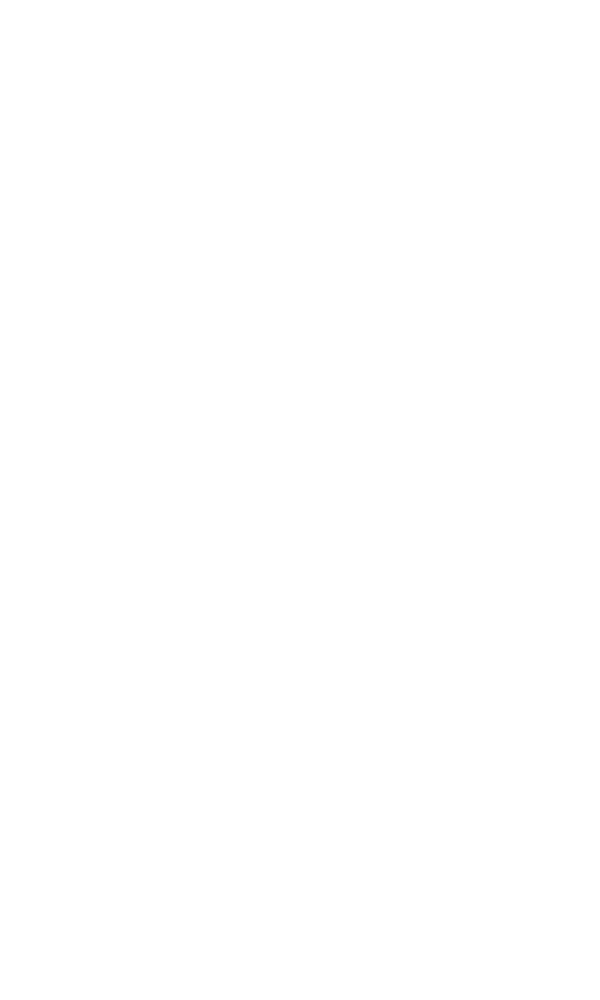

(66,)


In [24]:
row_bin_centers = []
row_bin_stddev = []
row_bin_amplitude = []
for y in range(bin_centers.size):
    bin_fit = fitter(fit_extraction_kernel, xd_pixels, binned_spectrum[:, y])
    bin_fwhms[y] = bin_fit.stddev_0.value
    row_bin_centers.append(bin_fit.mean_0.value)
    row_bin_stddev.append(bin_fit.stddev_0.value)
    row_bin_amplitude.append(bin_fit.amplitude_0.value)
    
bin_ny, bin_nx = binned_spectrum.shape
bin_ar = bin_nx / (3 * bin_ny)

fig_fwhm, ax_fwhm = plt.subplots(nrows=2, ncols=1, figsize=(6, 10))
plt.subplots_adjust(hspace=0.05)
fwhm_img = ax_fwhm[0].imshow(binned_spectrum, aspect=bin_ar, interpolation='none',
                             cmap='gray',origin='lower')
fwhm_plot = ax_fwhm[1].plot(bin_centers, row_bin_centers)
xlbl_fwhm = ax_fwhm[1].set_xlabel("Bin center (px)")
ylbl_fwhm = ax_fwhm[1].set_ylabel("FWHM (arcsec)")
print(bin_fwhms.shape)

In [25]:
trace_center_model = models.Polynomial1D(1) #we use a constant because the spectrum has already been rectified
trace_center_model.c0 = fit_extraction_kernel.mean_0.value # use the parameter for center of the PSF profile
print(trace_center_model)

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 1
Parameters:
            c0          c1
    ------------------ ---
    113.61301620426947 0.0


In [26]:
scale = 1.0 # adjust this if and when the NIRSpec PIXFRAC changes

# We want any pixel with 0 weight to be excluded from the calculation
# in the next step, so we'll use masked array operations.
bad_pixels = weights_region == 0
masked_wht = np.ma.array(weights_region, mask=bad_pixels)
variance_image = np.ma.divide(1., weights_region * scale**4)
print(variance_image[20:])

[[1.021516435801905 1.0203012719918223 1.0135892576239323 ...
  0.9813294140034793 0.9785062186374407 0.9741008647470487]
 [1.0186614429684733 1.0330405614264533 1.022710420797151 ...
  0.9848478085253313 0.9799500239231568 0.9755861991448332]
 [1.0360348615523585 1.049116696964502 1.0319972350609163 ...
  0.9874745769361643 0.9832851099528905 0.9729158497240715]
 ...
 [1.0175239092521486 0.9995702741534382 1.030827170168557 ...
  1.0052124778302307 1.0020906881648755 1.003767844723362]
 [1.0431513002121342 0.9995702741534382 1.0007590138565408 ...
  1.0043035521922659 1.001247028848359 1.0007650784658066]
 [1.0169560945706466 1.0185883991233413 1.0314118707755726 ...
  0.9993336973492379 0.9984905497975228 0.9972359026250571]]


<IPython.core.display.Javascript object>


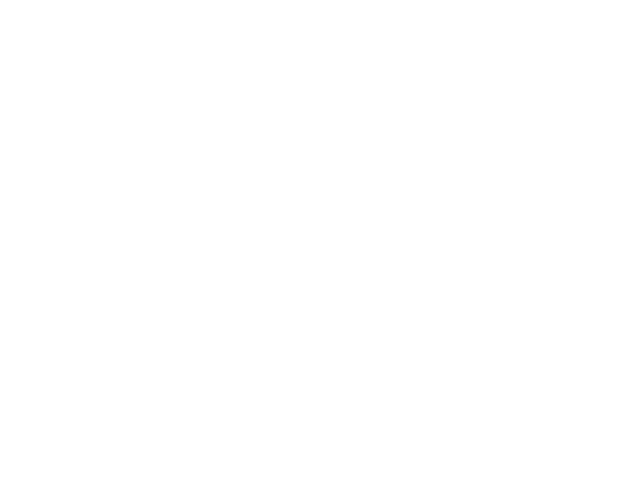

In [27]:
from copy import copy

fig_var = plt.figure()
palette = copy(plt.cm.gray)
palette.set_bad('r', alpha=0.7)
var_norm = simple_norm(variance_image, stretch='log',)
img_var = plt.imshow(variance_image, interpolation='none', aspect=aspect_ratio, norm=var_norm, cmap=palette)

In [28]:
spectrum = np.zeros(er_nx, dtype=float) #initialize our spectrum with zeros
spectrum_t = spectrum.copy()
column_pixels = np.arange(er_nx)
trace_centers = trace_center_model(column_pixels) # calculate our trace centers array
bkg_cols = np.zeros_like(extraction_region)
rbc_i = -1
xrows = extraction_region.shape[0]
for x in column_pixels:
    # create the kernel for this column, using the fit trace centers
    kernel_column = fit_extraction_kernel.copy()
    kmean_i = kernel_column.mean_0
    kernel_column.mean_0 = row_bin_centers[rbc_i]#trace_centers[x]
    kernel_column.stddev_0 = row_bin_stddev[rbc_i]
    kernel_column.amplitude_0 = row_bin_amplitude[rbc_i]
    
   
    if x % len(row_bin_centers) == 0:
        #print(rbc_i)
        rbc_i+=1
        
    
    # kernel_column.stddev_0 = fwhm_fit(x) # if accounting for a varying FWHM, uncomment this line.
    # kernel_values = kernel_column(xd_pixels)
    xd_pixels_init = int(kernel_column.mean_0.value)-3*int(kernel_column.stddev_0.value)
    
    xd_pixels_end = int(kernel_column.mean_0.value)+3*int(kernel_column.stddev_0.value)
    
    rows_bg = np.append(np.arange(0,xd_pixels_init),
                                np.arange(xd_pixels_end,extraction_region.shape[0]))
    
    pfit = np.polyfit(rows_bg, extraction_region[rows_bg, x], 2) # Fit poly over bkg rows for col
    bkg_cols[:, x] = np.polyval(pfit, xrows) 
    image_pix = extraction_region[:,x]
    bgs_image = image_pix - np.polyval(pfit,xrows)
    kernel_values = kernel_column(xd_pixels[xd_pixels_init:xd_pixels_end])
    
    # isolate the relevant column in the spectrum and variance images
    variance_column = variance_image[xd_pixels_init:xd_pixels_end, x] # remember that numpy arrays are row, column
    image_pixels = extraction_region[xd_pixels_init:xd_pixels_end, x] - np.polyval(pfit,xrows)
    
    # calculate the kernal normalization
    g_x = np.ma.sum(kernel_values**2 / variance_column)
    if np.ma.is_masked(g_x): #this column isn't valid, so we'll skip it
        continue
    
    # and now sum the weighted column
    weighted_column = np.ma.divide(image_pixels * kernel_values, variance_column)
    spectrum[x] = np.ma.sum(weighted_column) / g_x
    spectrum_t[x] = bgs_image.sum(axis=0)

spectrum_t,spectrum,weighted_column,image_pixels*kernel_values,variance_column

(array([1614.24023438, 1077.84362793,  898.51635742, ..., 9054.88671875,
        9903.91601562, 9367.06640625]),
 array([0.00043248, 0.03095596, 0.03080806, ..., 0.0029099 , 0.00351509,
        0.00320093]),
 masked_array(data=[795287.3086444462, 1093103.0576389285,
                    1047752.9199784736, 910435.6012970883,
                    876570.3188585527, 450324.84377815237],
              mask=[False, False, False, False, False, False],
        fill_value=1e+20),
 array([ 799585.31779854, 1101542.15108604, 1053601.60312843,
         915014.41480311,  881671.29972425,  455217.54785936]),
 masked_array(data=[1.0054043477211039, 1.0077203090670515,
                    1.0055821205920172, 1.0050292557754805,
                    1.005819248902171, 1.0108648326842373],
              mask=[False, False, False, False, False, False],
        fill_value=1e+20))

<IPython.core.display.Javascript object>


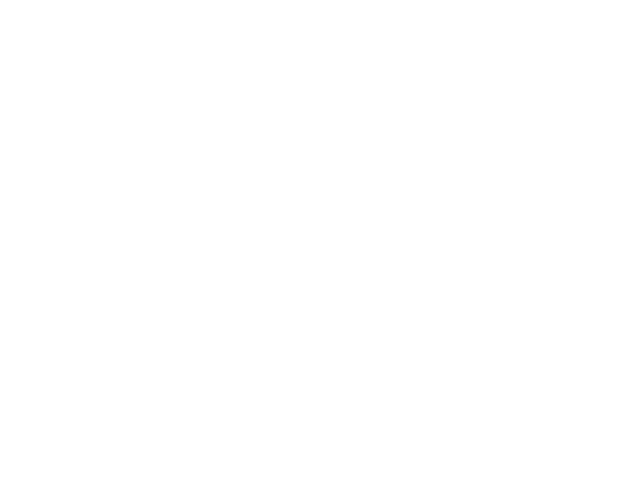

In [29]:
fig7 = plt.figure()
spec7 = plt.plot(column_pixels, spectrum)

In [30]:
import PIPELINE.pixel_mapping
importlib.reload(PIPELINE.pixel_mapping)
from PIPELINE.pixel_mapping import DMD, ImCam, do_transform, get_scale_matrix, get_rotation_matrix

nx = ny = 1080

img = CCDData.read(
    "/Users/danakoeppe/PipelineProjects/SAMOS_tools/rebinned_stitched_140307_001423_ori.fits")

dmd_arr = np.mat(np.random.randint(2,size=(nx,ny))) #np.mat(np.ndarray((nx,ny),dtype=int))

dmd_obj = DMD(dmd_arr=dmd_arr)

img_obj = ImCam(im_arr=img)
    
dmd_arr

matrix([[0, 0, 0, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 1, 0],
        [1, 0, 1, ..., 1, 1, 0],
        ...,
        [0, 0, 1, ..., 1, 0, 0],
        [0, 1, 0, ..., 0, 1, 1],
        [0, 0, 1, ..., 0, 1, 0]])

In [31]:
dmd_scale = 1./6. # arcsec/mirror
img_scale = 180./1024 # arcsec/pix

dmd_to_img_scale = dmd_scale/img_scale # pixels/mirror
img_to_dmd_scale = img_scale/dmd_scale # mirrors/pixel 

def get_new_rot_img_dims(angle_deg,in_width,in_height):
    
    theta_rad = np.radians(angle_deg)
    costheta = np.cos(theta_rad)
    sintheta = np.sin(theta_rad)
    new_width = round(np.abs(in_width*costheta)+np.abs(in_height*sintheta))+1
    new_height = round(np.abs(in_height*costheta)+np.abs(in_width*sintheta))+1
    
    return new_width, new_height

def get_new_centers(image,new_width,new_height):
original_centre_height   = round(((image.shape[0]+1)/2)-1)    #with respect to the original image
original_centre_width    = round(((image.shape[1]+1)/2)-1)    #with respect to the original image

# Find the centre of the new image that will be obtained
new_centre_height= round(((new_height+1)/2)-1)        #with respect to the new image
new_centre_width= round(((new_width+1)/2)-1) 

Tr = get_rotation_matrix(90)

Tr30 = get_rotation_matrix(30)
Ts = get_scale_matrix(scale_x=img_to_dmd_scale,scale_y=img_to_dmd_scale)

new_dmd_rows = new_dmd_cols = int(nx*dmd_to_img_scale)

old_img_rows = img_obj.im_arr.shape[0]
old_img_cols = img_obj.im_arr.shape[1]

new_img_rows30,new_img_cols30 = get_new_img_dims(30,in_width=old_img_cols,
                                                in_height=old_img_rows)

new_img_rows90,new_img_cols90 = get_new_img_dims(90,in_width=old_img_cols,
                                                in_height=old_img_rows)


transformed_dmd_shape = (int(nx*dmd_to_img_scale),int(ny*dmd_to_img_scale))
T = Tr @ Ts


#do_transform(t_mat=T,input_arr=dmd_obj.dmd_arr,new_arr_shape=transformed_dmd_shape)

a, b, c, d = (0, 1, 1), (1, 0, 1), (0, -1, 1), (-1, 0, 1)

# matrix with row vectors of points
A = np.array([a, b, c, d])

tryA = Tr @ A.T




IndentationError: expected an indented block (<ipython-input-31-b019759650be>, line 18)

In [ ]:
input_arr = img_obj.im_arr.data

pts_tr_arr = np.empty(A.shape)
rotated_img_dims = Tr @ np.array([input_arr.shape[0], input_arr.shape[1], 1])
rotated_img_shape = (1050,1050)#np.abs(rotated_img_dims.A1[:2].astype(int))
print(rotated_img_shape)
arr_scale_im_to_dmd = np.empty((new_img_rows, new_img_cols))

arr_rotate_im = np.empty((new_img_rows30, new_img_cols30), dtype=float)


def apply_transform(T, input_arr, transf_arr):
    for i, row in enumerate(input_arr):
        
        for j, col in enumerate(row):
            arr_data = input_arr[i, j]
            #print(arr_data)
            input_coords = np.array([i, j, 1])
            
            new_row = T @ input_coords.T
            i_out, j_out, _ = new_row.A1.astype(int)
            transf_arr[i_out, j_out] = arr_data
            #try:
            #    transf_arr[i_out, j_out] = arr_data
            #except:
            #    print(i_out,j_out,i,j)
    return transf_arr

rotated_pts = apply_transform(Tr, A, pts_tr_arr)
#scaled_img = apply_transform(Ts, input_arr, arr_scale_im_to_dmd)
rotated_img = apply_transform(Tr30, input_arr, arr_rotate_im)


In [ ]:
new_rows = []
trunc_inarr = input_arr[100:800][100:800]
result = np.zeros((Tr30.shape[0],trunc_inarr.shape[1]))
print(result.shape)
outrows = []
Tr30 = get_rotation_matrix(30)
Tr90 = get_rotation_matrix(90)

points_arr = []
for i in range(trunc_inarr.shape[0]):
    for j in range(trunc_inarr.shape[1]):
        points_arr.append(np.array([i, j, 1]))
        
points_arr = np.mat(points_arr)
tryA

In [ ]:

def get_outrows(Tr90,A):
    outrows = []
    
    for rrow in range(Tr90.shape[0]):
        new_row = []
        for acol in range(A.T.shape[1]):
            #print(rrow,acol)
            elem = 0
            for arow in range(A.T.shape[0]):
                
                
                Tij = Tr90[rrow,arow]
                Aij = A.T[arow,acol]
                
                
                #print((rrow,arow),(arow,acol))
                #print(Tij,Aij)
                elem += Tij*Aij
            #print(elem)
            new_row.append(int(elem))
        outrows.append(new_row)
        

    outrows = np.mat(np.array(outrows)).T[:,:-1]
    return outrows

outrows = get_outrows(Tr90,points_arr)


outrows

<IPython.core.display.Javascript object>


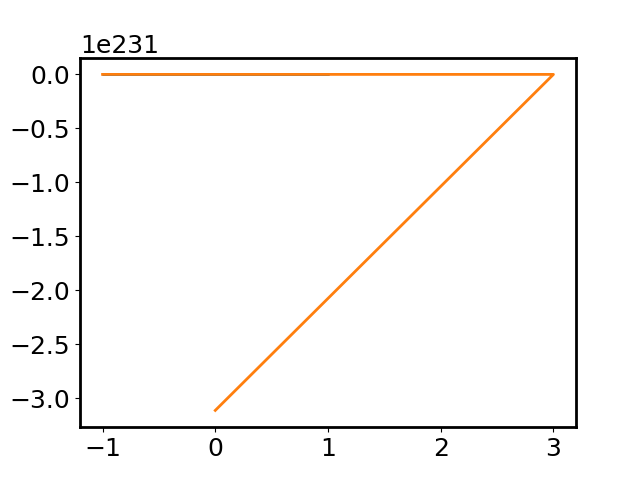

(array([ 0,  1,  0, -1,  0]),
 array([[ 0,  1,  0],
        [ 1,  0,  1],
        [ 0, -1,  2],
        [-1,  0,  3]]),
 array([ 1,  0, -1,  0,  1]))

In [338]:
plt.figure()
xorig = np.append(A[:,0],A[0,0])
yorig = np.append(A[:,1],A[0,1])

xnew1 = np.append(rotated_pts[:,0],rotated_pts[0,0])
ynew1 = np.append(rotated_pts[:,1],rotated_pts[0,1])

xnew2 = rotated_pts[:,0]
ynew2 = rotated_pts[:,1]


plt.plot(xorig,yorig)
plt.plot(xnew2,ynew2)
xorig,A,yorig

In [217]:
T_inv = np.linalg.inv(Ts)

# nearest neighbors interpolation
def nearest_neighbors(i, j, M, T_inv):
    x_max, y_max = M.shape[0] - 1, M.shape[1] - 1
    new_row = T_inv @ np.array([i, j, 1])
    x, y, _ = new_row.A1.astype(int)
    if np.floor(x) == x and np.floor(y) == y:
        x, y = int(x), int(y)
        return M[x, y]
    if np.abs(np.floor(x) - x) < np.abs(np.ceil(x) - x):
        x = int(np.floor(x))
    else:
        x = int(np.ceil(x))
    if np.abs(np.floor(y) - y) < np.abs(np.ceil(y) - y):
        y = int(np.floor(y))
    else:
        y = int(np.ceil(y))
    if x > x_max:
        x = x_max
    if y > y_max:
        y = y_max
    return M[x, y,]


img_nn = np.empty((new_img_rows, new_img_cols))

for i, row in enumerate(arr_transformed1):
    for j, col in enumerate(row):
        img_nn[i, j] = nearest_neighbors(i, j, input_arr, T_inv)
        

<IPython.core.display.Javascript object>


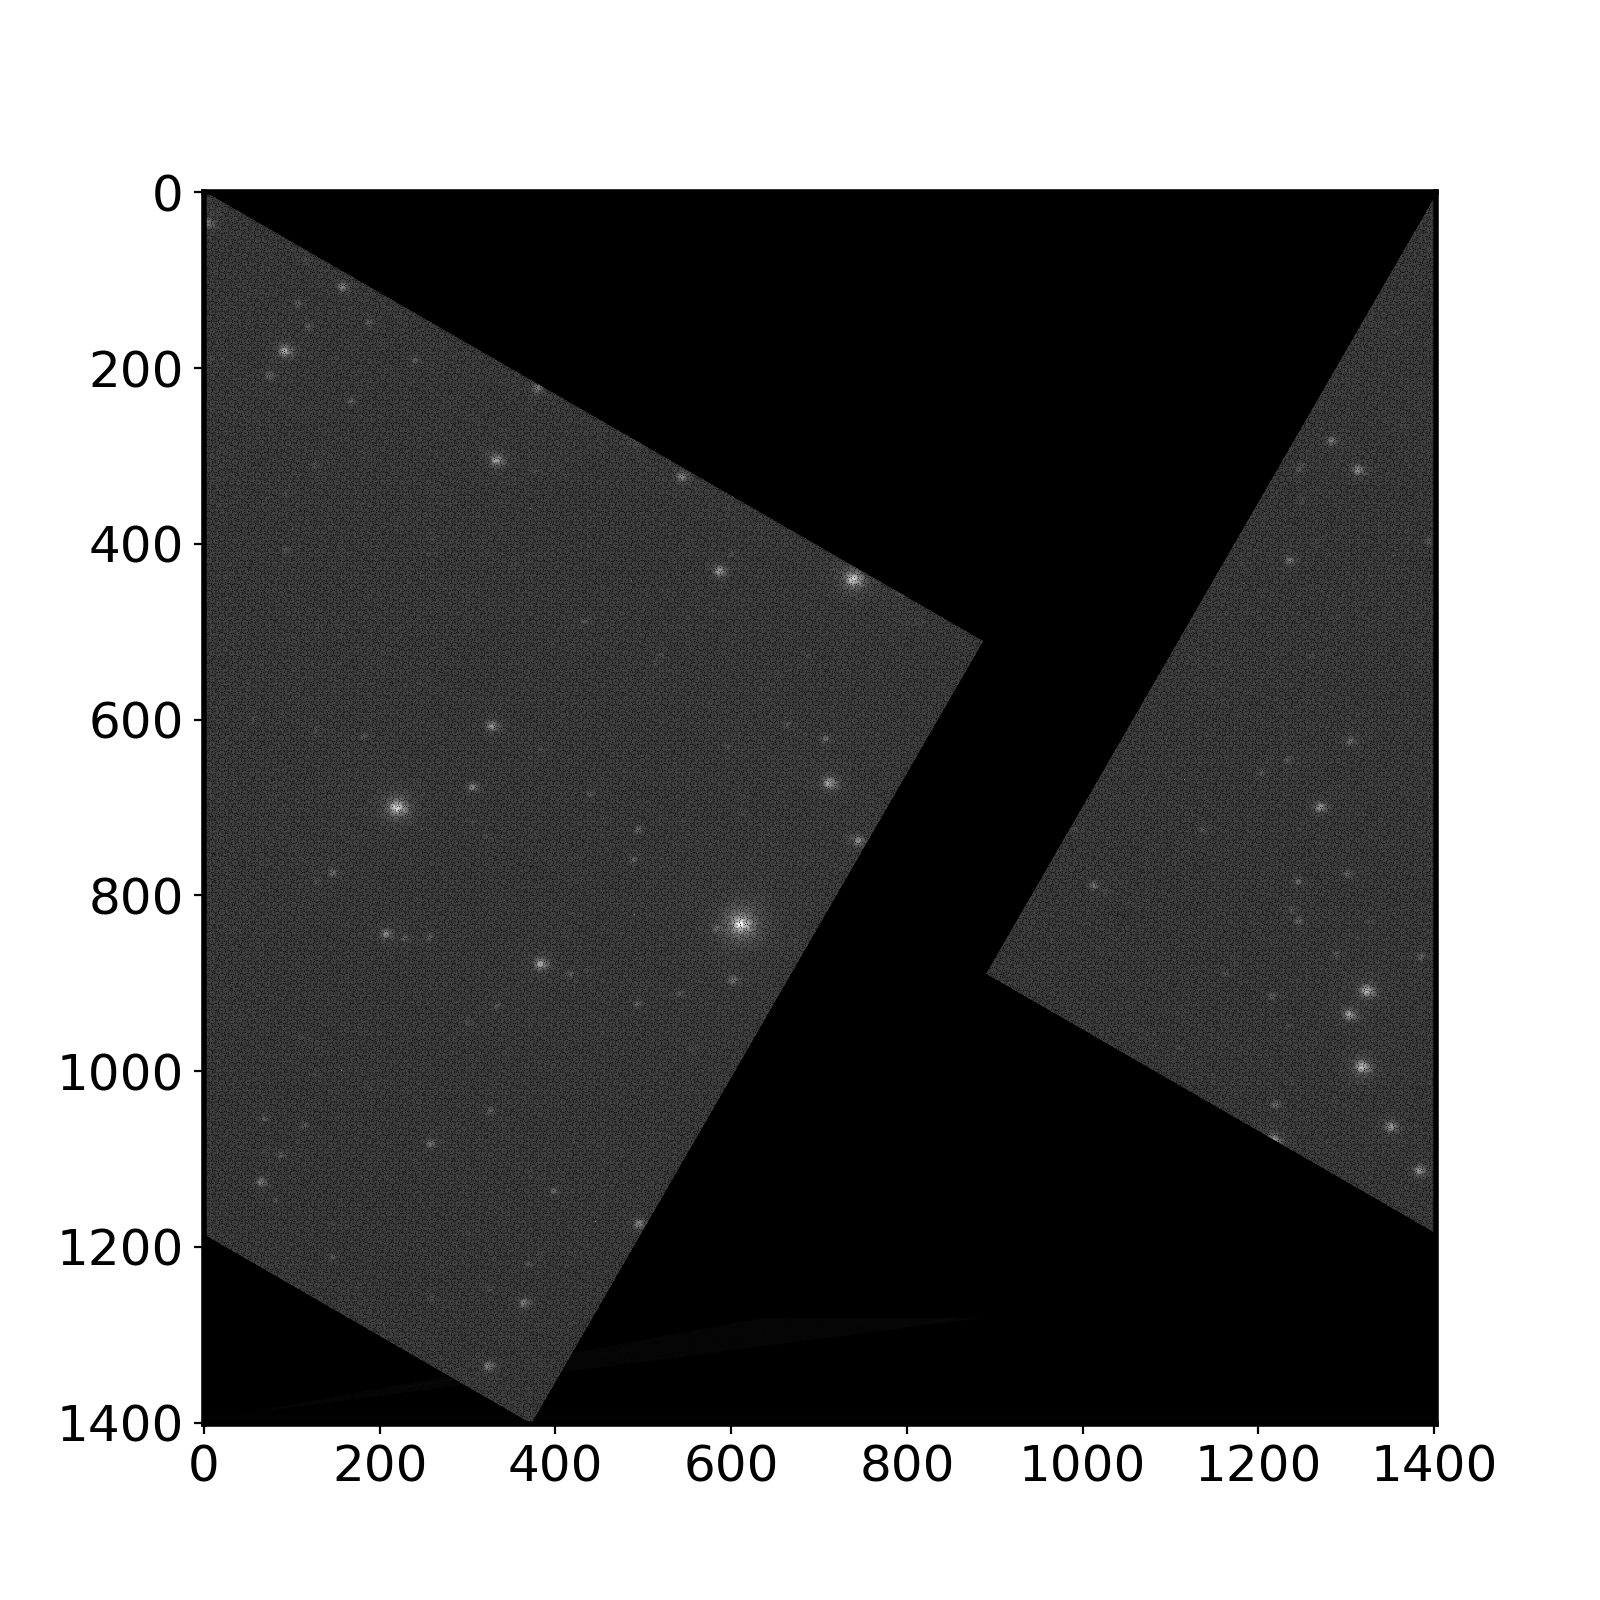

In [54]:


image_shape = img_obj.im_arr.data.shape
im_data = img_obj.im_arr.data
norm = simple_norm(im_data, stretch='log')
aspect_ratio = image_shape[1] / (2 * image_shape[0])
figtr = plt.figure(figsize=(8,8)) # we save these in dummy variables to avoid spurious Jupyter Notebook output
imgtr = plt.imshow(rotated_img, cmap='gray',)
                   #aspect=aspect_ratio, norm=norm, interpolation='none')
    


<IPython.core.display.Javascript object>


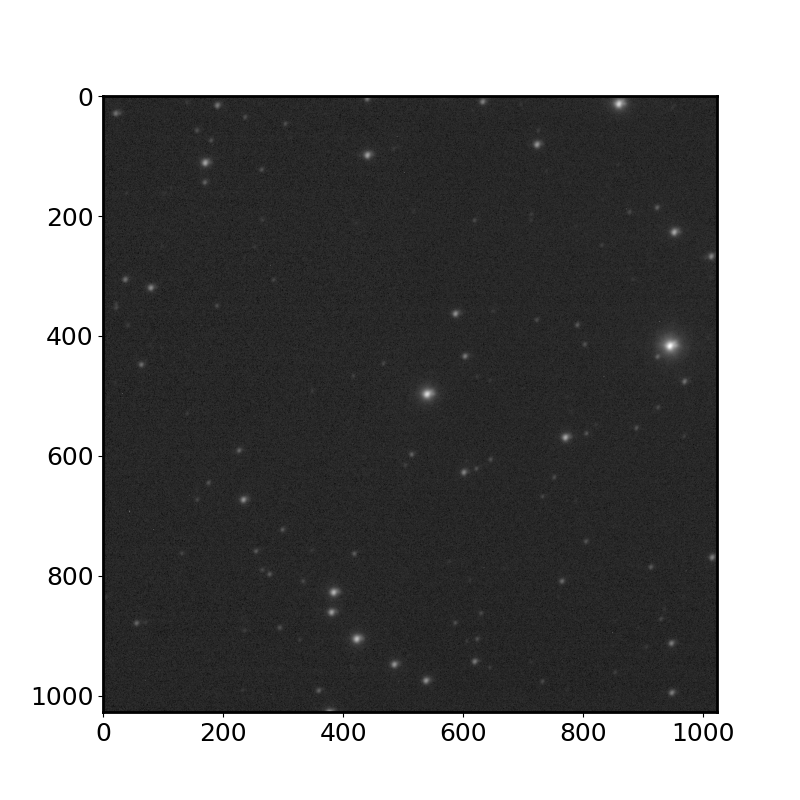

In [262]:
figtr = plt.figure(figsize=(8,8)) # we save these in dummy variables to avoid spurious Jupyter Notebook output
imgtr = plt.imshow(im_data, cmap='gray',)

In [100]:
xs = []
ys = []
outrows = []
for row in At:
    
    output_row = scale_mat @ row.T
    x, y, i = output_row
    xs.append(x)
    ys.append(y)
    
    i = int(i)
    outrows.append(output_row)

In [102]:
np.mat(np.array([i for i in outrows]))

matrix([[ 0.        ,  0.17578125,  0.        ],
        [ 0.17578125,  0.        ,  1.        ],
        [ 0.        , -0.17578125,  2.        ],
        [-0.17578125,  0.        ,  3.        ]])

In [111]:
ang = 30.
cos_ang = np.cos(np.radians(ang))
sin_ang = np.sin(np.radians(ang))

rot_mat = np.mat(np.array([[cos_ang, sin_ang, 0], 
							[-sin_ang, cos_ang, 0],
							[0, 0, 1]]))


In [112]:
scale_mat @ rot_mat

matrix([[ 0.15223103,  0.08789062,  0.        ],
        [-0.08789062,  0.15223103,  0.        ],
        [ 0.        ,  0.        ,  1.        ]])

In [108]:
np.pi/2

1.5707963267948966